# Introduction

This notebook shows how to train __SegNet__ on __Pascal VOC2007__ dataset.

This notebook and _segnet.py_ file are based on code from https://github.com/Sayan98/pytorch-segnet

My contributions include: 

* Convert code into jupyter notebook and add comments
* refactor and update most of the code
* one critical bug fix - original author was incorrectly feeding softmax output into CrossEntropyLoss
* few minor bug fixes
* many improvements

**References**

* [SegNet: A Deep Convolutional Encoder-Decoder Architecture for Image Segmentation](https://arxiv.org/abs/1511.00561) - detailed model description
* [The PASCAL Visual Object Classes (VOC) Challenge](http://host.robots.ox.ac.uk/pascal/VOC/) - dataset, format description
* [Pascal VOC Dataset Mirror](https://pjreddie.com/projects/pascal-voc-dataset-mirror/) - dataset download mirror
* [Sayan98 Github](https://github.com/Sayan98/pytorch-segnet) - SegNet original code

<div class="alert alert-info">

**Code is not tidied but definitely works**

</div>

# Imports

In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import PIL
import torch

import segnet  # segnet.py contains model definition

Acquire GPU device if available

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# VOC2007 Dataset

Download VOC2007 dataset from link in references. File should have name __VOCtrainval_06-Nov-2007.tar__ and weight approx 460MB. Extract VOC2007 folder and modify path below.

In [3]:
# Dataset v3
num_classes = 22                                        # background, airplane, ..., border
data_root = '/home/marcin/Datasets/VOC2007'             # Dataset location
batch_size = 16                                         # Mini-batch size

Class names, for reference only

In [5]:
# for reference, not used in this notebook
voc_classes = ('background',  # always index 0
               'aeroplane', 'bicycle', 'bird', 'boat',  # indices 1, 2, 3, 4
               'bottle', 'bus', 'car', 'cat', 'chair',  #         5, ...
               'cow', 'diningtable', 'dog', 'horse',
               'motorbike', 'person', 'pottedplant',
               'sheep', 'sofa', 'train', 'tvmonitor',   #         ..., 21
               'border')                                # but border has index 255 (!)
assert num_classes == len(voc_classes)

Class below reads segmentation dataset in VOC2007 compatible format.

In [6]:
class PascalVOCDataset(torch.utils.data.Dataset):
    """Pascal VOC2007 or compatible dataset"""
    
    def __init__(self, num_classes, list_file, img_dir, mask_dir, transform=None):
        self.num_classes = num_classes
        self.images = open(list_file, "rt").read().split("\n")[:-1]
        self.transform = transform
        self.img_extension = ".jpg"
        self.mask_extension = ".png"
        self.image_root_dir = img_dir
        self.mask_root_dir = mask_dir
        self.counts = self.__compute_class_probability()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        name = self.images[index]
        image_path = os.path.join(self.image_root_dir, name + self.img_extension)
        mask_path = os.path.join(self.mask_root_dir, name + self.mask_extension)

        image = self.load_image(path=image_path)
        gt_mask = self.load_mask(path=mask_path)

        return torch.FloatTensor(image), torch.LongTensor(gt_mask)

    def __compute_class_probability(self):
        counts = dict((i, 0) for i in range(self.num_classes))

        for name in self.images:
            mask_path = os.path.join(self.mask_root_dir, name + self.mask_extension)
            raw_image = PIL.Image.open(mask_path).resize((224, 224))
            imx_t = np.array(raw_image).reshape(224*224)
            imx_t[imx_t==255] = self.num_classes-1    # convert VOC border into last class
            for i in range(self.num_classes):
                counts[i] += np.sum(imx_t == i)

        return counts

    def get_class_probability(self):
        values = np.array(list(self.counts.values()))
        p_values = values/np.sum(values)
        return torch.Tensor(p_values)

    def load_image(self, path=None):
        raw_image = PIL.Image.open(path)
        raw_image = np.transpose(raw_image.resize((224, 224)), (2,1,0))
        imx_t = np.array(raw_image, dtype=np.float32)/255.0
        return imx_t

    def load_mask(self, path=None):
        raw_image = PIL.Image.open(path)
        raw_image = raw_image.resize((224, 224))
        imx_t = np.array(raw_image)
        imx_t[imx_t==255] = self.num_classes-1        # convert VOC border into last class
        return imx_t

Dataset internal structure, no need to modify this

In [7]:
train_path = os.path.join(data_root, 'ImageSets/Segmentation/train.txt')
val_path = os.path.join(data_root, 'ImageSets/Segmentation/val.txt')
img_dir = os.path.join(data_root, "JPEGImages")
mask_dir = os.path.join(data_root, "SegmentationClass")

Create train and validation datasets

In [8]:
train_dataset = PascalVOCDataset(num_classes=num_classes, list_file=train_path,
                                 img_dir=img_dir, mask_dir=mask_dir)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                              shuffle=True, num_workers=4)

In [9]:
val_dataset = PascalVOCDataset(num_classes=num_classes, list_file=val_path,
                               img_dir=img_dir, mask_dir=mask_dir)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                            shuffle=True, num_workers=4)

Dataset statistics

In [13]:
print('Train Dataset:')
print('  length:', len(train_dataset))
print('  classes:', train_dataset.counts)
print()
print('Validation Dataset:')
print('  length:', len(val_dataset))
print('  classes:', val_dataset.counts)

Train Dataset:
  length: 209
  classes: {0: 7159962, 1: 48254, 2: 43413, 3: 88928, 4: 46910, 5: 70999, 6: 199300, 7: 74579, 8: 187365, 9: 111148, 10: 78270, 11: 131729, 12: 143997, 13: 85963, 14: 79197, 15: 907370, 16: 31601, 17: 23115, 18: 168819, 19: 119886, 20: 130575, 21: 555404}

Validation Dataset:
  length: 213
  classes: {0: 7510688, 1: 92925, 2: 22092, 3: 96791, 4: 45749, 5: 50854, 6: 174952, 7: 75774, 8: 235244, 9: 90788, 10: 89584, 11: 173030, 12: 82166, 13: 102124, 14: 157234, 15: 605066, 16: 48866, 17: 170058, 18: 91310, 19: 207354, 20: 52445, 21: 512394}


Show example image and mask

image shape: [224, 224, 3]
mask shape:  [224, 224]


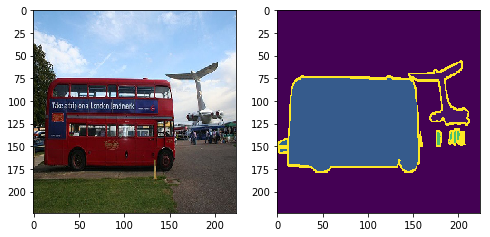

In [14]:
image, mask = train_dataset[11]
image.transpose_(0, 2)

print('image shape:', list(image.shape))
print('mask shape: ', list(mask.shape))

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
ax1.imshow(image)
ax2.imshow(mask)
plt.show()

Construct mini-batch of test images. This is a one-element mini-batch used to plot model predictions as it trains.

In [20]:
test_image_idx = 11  # only one image, but could be more
test_images = train_dataset[test_image_idx][0].unsqueeze(0)
test_masks = train_dataset[test_image_idx][1].unsqueeze(0)

Helper for plotting, used a bit later

In [21]:
def plot_test_batch(test_images, test_logits, test_masks):
    for i in range(len(test_images)):
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4,
                                                 figsize=(12, 4*len(test_images)))
        ax1.imshow(test_images[i].transpose(0, 2).numpy()); ax1.set_title('Input Image')

        predicted_mx = test_logits[i].numpy()
        predicted_mx = predicted_mx.argmax(axis=0)
        ax2.imshow(predicted_mx, vmin=0, vmax=num_classes); ax2.set_title('Predicted Mask')

        target_mx = test_masks[i].numpy()
        ax3.imshow(target_mx, vmin=0, vmax=num_classes); ax3.set_title('Ground Truth')
        
        acc_mx = predicted_mx != target_mx
        ax4.imshow(acc_mx); ax4.set_title('Prediction Errors')
        
        plt.show()

# Train SegNet

In [38]:
save_model_path = './models/model_best.pth'
learning_rate = 1e-6  # 1e-6

Create directory to save model to

In [48]:
dir_path = os.path.split(save_model_path)[0]
if not os.path.exists(dir_path):
    os.makedirs(dir_path)

Create model

In [49]:
model = segnet.SegNet(input_channels=3, output_channels=num_classes).to(device)
class_weights = 1.0 / train_dataset.get_class_probability().to(device)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Optionally test model on randomly generated input mini-batch.

In [50]:
test_model_on_random_input = False

if test_model_on_random_input:
    img = torch.randn([4, 3, 224, 224]).to(device)
    logits, probabilities = model(img)

    print(logits.size())
    print(probabilities.size())

    print(logits[0,:,0,0])
    print(probabilities[0,:,0,0].sum())

Test model on `test_images`

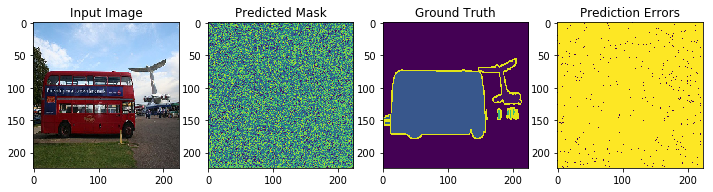

In [51]:
with torch.no_grad():
    test_logits, _ = model(test_images.to(device))        # pass through model
    test_logits = test_logits.cpu()
    plot_test_batch(test_images, test_logits, test_masks)

Helper for plotting

In [52]:
def plot_trace(trace):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    ax1.plot(trace['tloss'], label='train loss')
    ax1.plot(trace['vloss'], label='valid loss')
    ax1.set_xlabel('Epoch')
    ax1.legend()
    
    ax2.plot(trace['tacc'], label='train acc')
    ax2.plot(trace['vacc'], label='valid acc')
    ax2.set_xlabel('Epoch')
    ax2.legend()
    plt.show()

Calc accuracy, returns tensor

In [53]:
def accuracy(logits, labels): 
    predictions = torch.argmax(logits, dim=1)
    return (predictions == labels).float().mean()  # tensor!!

Helper function for training

In [54]:
def train(nb_epochs, trace):
    
    prev_loss = float('inf')
    epoch = len(trace['epoch'])

    for _ in range(nb_epochs):
        
        time_start = time.time()

        #
        #   Train Model
        #
        model.train()
        tloss_sum, tacc_sum = 0, 0
        for inputs, targets in train_dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            logits, _ = model(inputs)
            loss = criterion(logits, targets)
            loss.backward()
            optimizer.step()
            
            with torch.no_grad():
                acc = accuracy(logits, targets)
                tloss_sum += loss.item() * len(inputs)
                tacc_sum  += acc.item() * len(inputs)
        
        tloss_avg = tloss_sum / len(train_dataset)
        tacc_avg = tacc_sum / len(train_dataset)
        
        #
        #   Evaluate Model
        #
        model.eval()
        with torch.no_grad():
            vloss_sum, vacc_sum = 0, 0
            for inputs, targets in val_dataloader:
                inputs = inputs.to(device)
                targets = targets.to(device)

                logits, _ = model(inputs)
                loss = criterion(logits, targets)

                acc = accuracy(logits, targets)
                vloss_sum += loss.item() * len(inputs)
                vacc_sum += acc.item() * len(inputs)

            vloss_avg = vloss_sum / len(val_dataset)
            vacc_avg = vacc_sum / len(val_dataset)
                
        #
        #   Logging
        #
        
        time_delta = time.time() - time_start
            
        trace['epoch'].append(epoch)
        trace['tloss'].append(tloss_avg)
        trace['tacc'].append(tacc_avg)
        trace['vloss'].append(vloss_avg)
        trace['vacc'].append(vacc_avg)
        
        if vloss_avg < prev_loss:
            prev_loss = vloss_avg
            if save_model_path is not None:
                torch.save(model.state_dict(), save_model_path)
                
        print(f'Epoch: {epoch:3}     T/V Loss: {tloss_avg:.4f} / {vloss_avg:.4f}     '
              f'T/V Acc: {tacc_avg:.4f} / {vacc_avg:.4f}     Time: {time_delta:.2f}s')
        
        if (epoch+1) % 10 == 0:
            plot_trace(trace)
            
            with torch.no_grad():
                test_logits, _ = model(test_images.to(device))        # pass through model
                test_logits = test_logits.cpu()
                plot_test_batch(test_images, test_logits, test_masks)
        
        epoch += 1

Do actual training

Epoch:   0     T/V Loss: 3.1828 / 3.0862     T/V Acc: 0.0220 / 0.0074     Time: 9.81s
Epoch:   1     T/V Loss: 3.1775 / 3.0800     T/V Acc: 0.0217 / 0.0181     Time: 9.81s
Epoch:   2     T/V Loss: 3.1763 / 3.0699     T/V Acc: 0.0214 / 0.0282     Time: 9.93s
Epoch:   3     T/V Loss: 3.1737 / 3.0664     T/V Acc: 0.0215 / 0.0264     Time: 9.84s
Epoch:   4     T/V Loss: 3.1712 / 3.0872     T/V Acc: 0.0213 / 0.0250     Time: 10.05s
Epoch:   5     T/V Loss: 3.1718 / 3.0990     T/V Acc: 0.0213 / 0.0244     Time: 10.55s
Epoch:   6     T/V Loss: 3.1662 / 3.0963     T/V Acc: 0.0213 / 0.0243     Time: 10.44s
Epoch:   7     T/V Loss: 3.1662 / 3.1031     T/V Acc: 0.0212 / 0.0241     Time: 10.34s
Epoch:   8     T/V Loss: 3.1667 / 3.1125     T/V Acc: 0.0211 / 0.0241     Time: 10.34s
Epoch:   9     T/V Loss: 3.1684 / 3.0990     T/V Acc: 0.0213 / 0.0241     Time: 10.40s


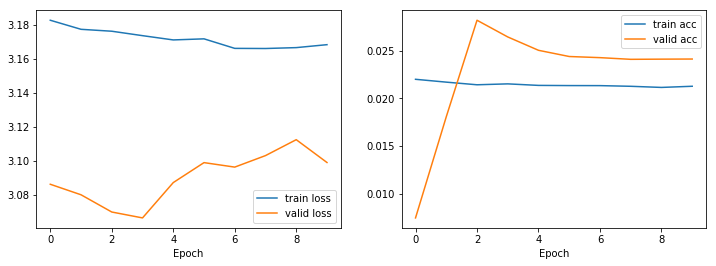

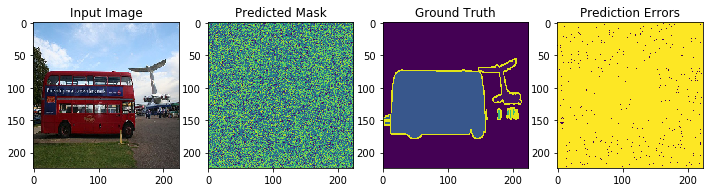

Epoch:  10     T/V Loss: 3.1630 / 3.1030     T/V Acc: 0.0214 / 0.0239     Time: 10.33s
Epoch:  11     T/V Loss: 3.1565 / 3.1000     T/V Acc: 0.0214 / 0.0240     Time: 10.42s
Epoch:  12     T/V Loss: 3.1612 / 3.1009     T/V Acc: 0.0215 / 0.0241     Time: 10.45s
Epoch:  13     T/V Loss: 3.1627 / 3.0992     T/V Acc: 0.0215 / 0.0242     Time: 10.44s
Epoch:  14     T/V Loss: 3.1550 / 3.0918     T/V Acc: 0.0215 / 0.0241     Time: 10.46s
Epoch:  15     T/V Loss: 3.1631 / 3.1036     T/V Acc: 0.0216 / 0.0243     Time: 10.47s
Epoch:  16     T/V Loss: 3.1574 / 3.1030     T/V Acc: 0.0216 / 0.0243     Time: 10.47s
Epoch:  17     T/V Loss: 3.1575 / 3.0881     T/V Acc: 0.0219 / 0.0244     Time: 10.49s
Epoch:  18     T/V Loss: 3.1554 / 3.0961     T/V Acc: 0.0218 / 0.0245     Time: 10.51s
Epoch:  19     T/V Loss: 3.1535 / 3.1025     T/V Acc: 0.0219 / 0.0246     Time: 10.48s


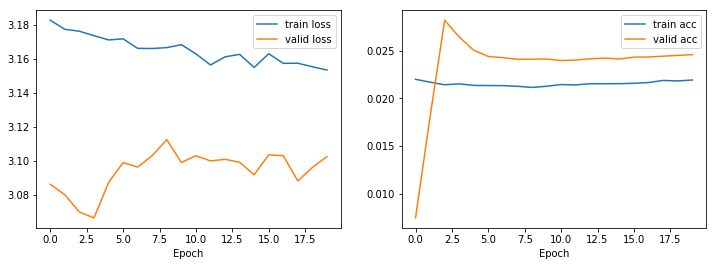

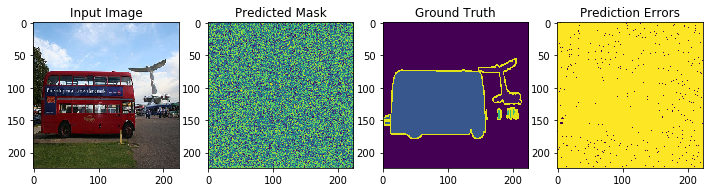

In [55]:
trace = {'epoch': [], 'tloss': [], 'vloss': [], 'tacc': [], 'vacc': []}
train(nb_epochs=20, trace=trace)

Epoch:  20     T/V Loss: 3.1483 / 3.0975     T/V Acc: 0.0219 / 0.0246     Time: 9.85s
Epoch:  21     T/V Loss: 3.1553 / 3.0901     T/V Acc: 0.0220 / 0.0245     Time: 9.87s
Epoch:  22     T/V Loss: 3.1520 / 3.0999     T/V Acc: 0.0223 / 0.0247     Time: 9.86s
Epoch:  23     T/V Loss: 3.1494 / 3.1027     T/V Acc: 0.0221 / 0.0248     Time: 9.99s
Epoch:  24     T/V Loss: 3.1513 / 3.0854     T/V Acc: 0.0222 / 0.0248     Time: 10.17s
Epoch:  25     T/V Loss: 3.1526 / 3.1122     T/V Acc: 0.0221 / 0.0249     Time: 10.43s
Epoch:  26     T/V Loss: 3.1484 / 3.0860     T/V Acc: 0.0224 / 0.0249     Time: 10.49s
Epoch:  27     T/V Loss: 3.1491 / 3.0889     T/V Acc: 0.0225 / 0.0250     Time: 10.47s
Epoch:  28     T/V Loss: 3.1483 / 3.0849     T/V Acc: 0.0225 / 0.0250     Time: 10.48s
Epoch:  29     T/V Loss: 3.1497 / 3.0788     T/V Acc: 0.0225 / 0.0251     Time: 10.23s


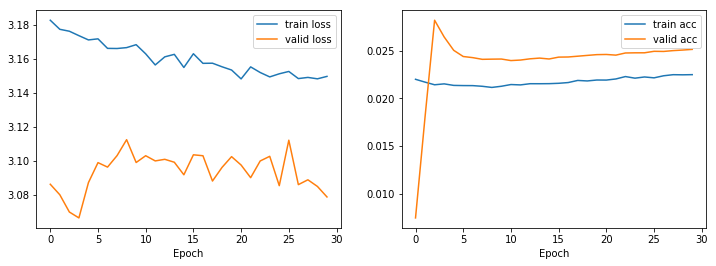

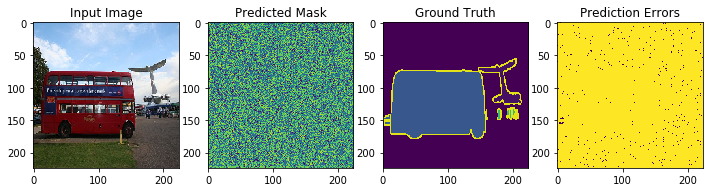

Epoch:  30     T/V Loss: 3.1496 / 3.0816     T/V Acc: 0.0227 / 0.0251     Time: 10.11s
Epoch:  31     T/V Loss: 3.1465 / 3.0900     T/V Acc: 0.0225 / 0.0252     Time: 10.53s
Epoch:  32     T/V Loss: 3.1512 / 3.0775     T/V Acc: 0.0226 / 0.0254     Time: 10.78s
Epoch:  33     T/V Loss: 3.1446 / 3.0816     T/V Acc: 0.0228 / 0.0255     Time: 10.19s
Epoch:  34     T/V Loss: 3.1441 / 3.0950     T/V Acc: 0.0228 / 0.0255     Time: 10.59s
Epoch:  35     T/V Loss: 3.1480 / 3.0821     T/V Acc: 0.0229 / 0.0255     Time: 10.55s
Epoch:  36     T/V Loss: 3.1474 / 3.1011     T/V Acc: 0.0231 / 0.0257     Time: 10.56s
Epoch:  37     T/V Loss: 3.1404 / 3.0924     T/V Acc: 0.0231 / 0.0258     Time: 10.55s
Epoch:  38     T/V Loss: 3.1436 / 3.1029     T/V Acc: 0.0231 / 0.0258     Time: 10.56s
Epoch:  39     T/V Loss: 3.1417 / 3.0839     T/V Acc: 0.0231 / 0.0258     Time: 10.57s


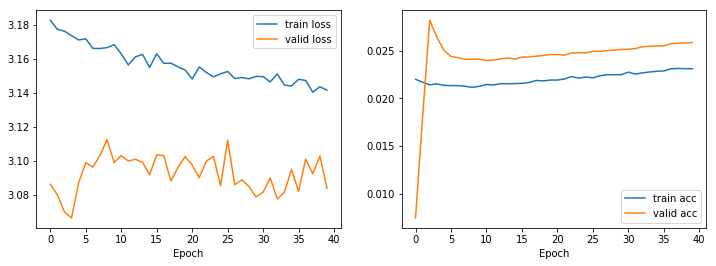

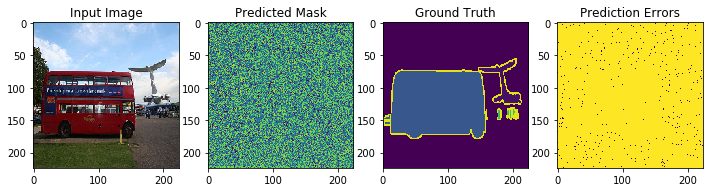

In [56]:
train(nb_epochs=20, trace=trace)

Epoch:  40     T/V Loss: 3.1367 / 3.0892     T/V Acc: 0.0234 / 0.0260     Time: 10.53s
Epoch:  41     T/V Loss: 3.1343 / 3.0907     T/V Acc: 0.0233 / 0.0260     Time: 10.20s
Epoch:  42     T/V Loss: 3.1418 / 3.0934     T/V Acc: 0.0237 / 0.0261     Time: 10.51s
Epoch:  43     T/V Loss: 3.1371 / 3.0860     T/V Acc: 0.0235 / 0.0263     Time: 10.55s
Epoch:  44     T/V Loss: 3.1445 / 3.0842     T/V Acc: 0.0237 / 0.0263     Time: 10.23s
Epoch:  45     T/V Loss: 3.1340 / 3.0879     T/V Acc: 0.0237 / 0.0264     Time: 10.20s
Epoch:  46     T/V Loss: 3.1363 / 3.0964     T/V Acc: 0.0238 / 0.0265     Time: 10.53s
Epoch:  47     T/V Loss: 3.1366 / 3.0894     T/V Acc: 0.0236 / 0.0265     Time: 10.55s
Epoch:  48     T/V Loss: 3.1333 / 3.0934     T/V Acc: 0.0240 / 0.0267     Time: 10.56s
Epoch:  49     T/V Loss: 3.1387 / 3.0985     T/V Acc: 0.0239 / 0.0266     Time: 10.57s


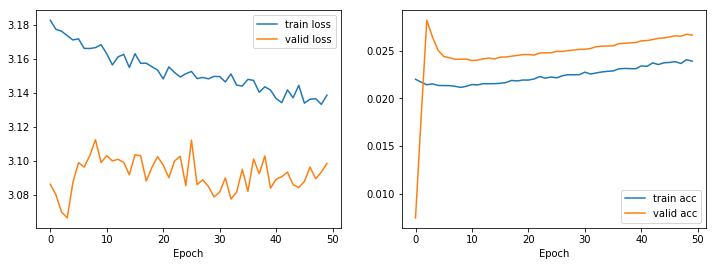

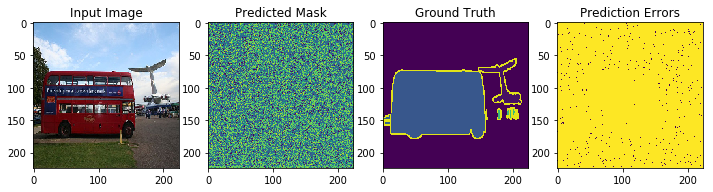

Epoch:  50     T/V Loss: 3.1362 / 3.1006     T/V Acc: 0.0239 / 0.0267     Time: 10.53s
Epoch:  51     T/V Loss: 3.1298 / 3.1012     T/V Acc: 0.0241 / 0.0267     Time: 10.59s
Epoch:  52     T/V Loss: 3.1307 / 3.0983     T/V Acc: 0.0240 / 0.0267     Time: 10.61s
Epoch:  53     T/V Loss: 3.1297 / 3.0959     T/V Acc: 0.0239 / 0.0268     Time: 10.71s
Epoch:  54     T/V Loss: 3.1264 / 3.0981     T/V Acc: 0.0240 / 0.0269     Time: 10.80s
Epoch:  55     T/V Loss: 3.1333 / 3.0877     T/V Acc: 0.0243 / 0.0268     Time: 10.62s
Epoch:  56     T/V Loss: 3.1263 / 3.0834     T/V Acc: 0.0238 / 0.0267     Time: 10.61s
Epoch:  57     T/V Loss: 3.1271 / 3.0867     T/V Acc: 0.0241 / 0.0267     Time: 10.25s
Epoch:  58     T/V Loss: 3.1258 / 3.0848     T/V Acc: 0.0241 / 0.0269     Time: 10.54s
Epoch:  59     T/V Loss: 3.1251 / 3.0926     T/V Acc: 0.0243 / 0.0268     Time: 10.68s


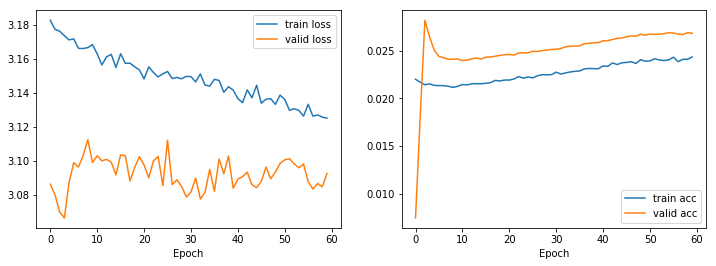

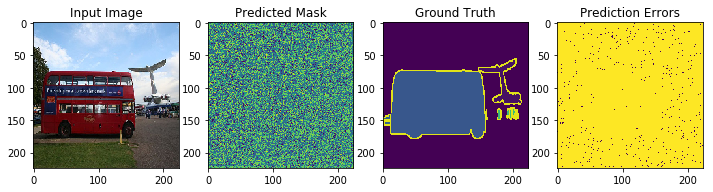

In [57]:
train(nb_epochs=20, trace=trace)

Epoch:  60     T/V Loss: 3.1213 / 3.0901     T/V Acc: 0.0243 / 0.0269     Time: 10.52s
Epoch:  61     T/V Loss: 3.1243 / 3.0898     T/V Acc: 0.0243 / 0.0270     Time: 10.17s
Epoch:  62     T/V Loss: 3.1220 / 3.0974     T/V Acc: 0.0242 / 0.0269     Time: 10.17s
Epoch:  63     T/V Loss: 3.1206 / 3.1040     T/V Acc: 0.0239 / 0.0269     Time: 10.61s
Epoch:  64     T/V Loss: 3.1261 / 3.1006     T/V Acc: 0.0241 / 0.0270     Time: 10.62s
Epoch:  65     T/V Loss: 3.1226 / 3.1050     T/V Acc: 0.0242 / 0.0270     Time: 10.81s
Epoch:  66     T/V Loss: 3.1150 / 3.0953     T/V Acc: 0.0244 / 0.0269     Time: 10.71s
Epoch:  67     T/V Loss: 3.1188 / 3.0865     T/V Acc: 0.0243 / 0.0271     Time: 10.57s
Epoch:  68     T/V Loss: 3.1163 / 3.0909     T/V Acc: 0.0241 / 0.0267     Time: 10.24s
Epoch:  69     T/V Loss: 3.1203 / 3.1000     T/V Acc: 0.0242 / 0.0271     Time: 10.54s


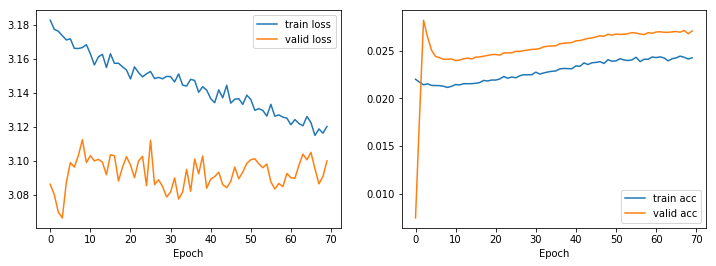

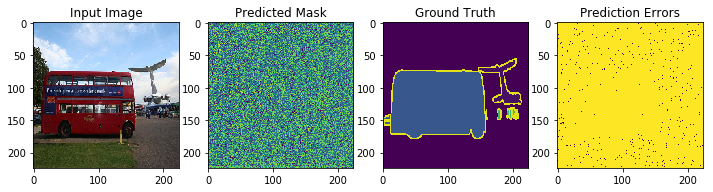

Epoch:  70     T/V Loss: 3.1088 / 3.0874     T/V Acc: 0.0242 / 0.0270     Time: 10.62s
Epoch:  71     T/V Loss: 3.1184 / 3.0933     T/V Acc: 0.0242 / 0.0271     Time: 10.67s
Epoch:  72     T/V Loss: 3.1163 / 3.0915     T/V Acc: 0.0245 / 0.0269     Time: 10.72s
Epoch:  73     T/V Loss: 3.1133 / 3.0995     T/V Acc: 0.0245 / 0.0270     Time: 10.82s
Epoch:  74     T/V Loss: 3.1173 / 3.0937     T/V Acc: 0.0243 / 0.0271     Time: 10.73s
Epoch:  75     T/V Loss: 3.1166 / 3.0949     T/V Acc: 0.0244 / 0.0270     Time: 10.66s
Epoch:  76     T/V Loss: 3.1129 / 3.0841     T/V Acc: 0.0242 / 0.0266     Time: 10.58s
Epoch:  77     T/V Loss: 3.1109 / 3.0819     T/V Acc: 0.0240 / 0.0264     Time: 10.21s
Epoch:  78     T/V Loss: 3.1099 / 3.0971     T/V Acc: 0.0241 / 0.0268     Time: 10.17s
Epoch:  79     T/V Loss: 3.1101 / 3.0882     T/V Acc: 0.0240 / 0.0269     Time: 10.53s


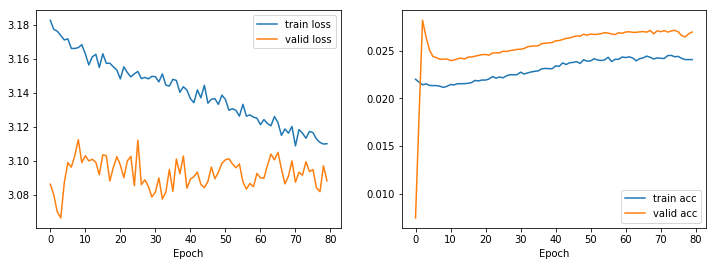

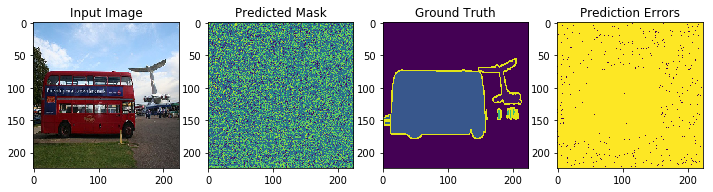

In [58]:
train(nb_epochs=20, trace=trace)

Epoch:  80     T/V Loss: 3.1116 / 3.0918     T/V Acc: 0.0244 / 0.0269     Time: 10.58s
Epoch:  81     T/V Loss: 3.1097 / 3.0980     T/V Acc: 0.0242 / 0.0267     Time: 10.22s
Epoch:  82     T/V Loss: 3.1129 / 3.0843     T/V Acc: 0.0240 / 0.0265     Time: 10.59s
Epoch:  83     T/V Loss: 3.1066 / 3.0879     T/V Acc: 0.0241 / 0.0266     Time: 10.26s
Epoch:  84     T/V Loss: 3.0999 / 3.0830     T/V Acc: 0.0238 / 0.0262     Time: 10.59s
Epoch:  85     T/V Loss: 3.1107 / 3.0942     T/V Acc: 0.0242 / 0.0264     Time: 10.22s
Epoch:  86     T/V Loss: 3.1051 / 3.0871     T/V Acc: 0.0240 / 0.0266     Time: 10.61s
Epoch:  87     T/V Loss: 3.1023 / 3.0889     T/V Acc: 0.0244 / 0.0263     Time: 10.73s
Epoch:  88     T/V Loss: 3.1060 / 3.0886     T/V Acc: 0.0240 / 0.0263     Time: 10.80s
Epoch:  89     T/V Loss: 3.1082 / 3.0878     T/V Acc: 0.0239 / 0.0261     Time: 10.62s


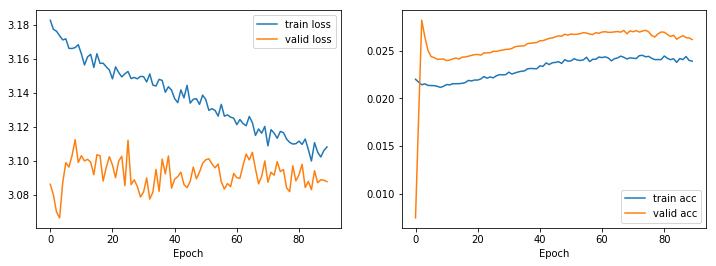

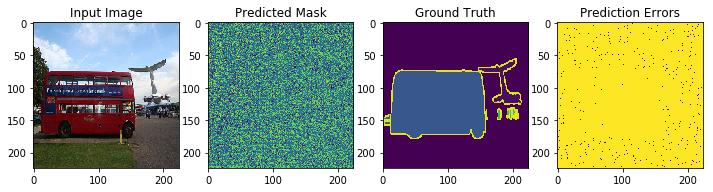

Epoch:  90     T/V Loss: 3.1002 / 3.0950     T/V Acc: 0.0239 / 0.0263     Time: 10.55s
Epoch:  91     T/V Loss: 3.0991 / 3.0985     T/V Acc: 0.0239 / 0.0266     Time: 10.63s
Epoch:  92     T/V Loss: 3.1033 / 3.0886     T/V Acc: 0.0240 / 0.0263     Time: 10.78s
Epoch:  93     T/V Loss: 3.1036 / 3.0900     T/V Acc: 0.0237 / 0.0260     Time: 10.70s
Epoch:  94     T/V Loss: 3.1019 / 3.0925     T/V Acc: 0.0239 / 0.0261     Time: 10.65s
Epoch:  95     T/V Loss: 3.1028 / 3.0912     T/V Acc: 0.0238 / 0.0261     Time: 10.71s
Epoch:  96     T/V Loss: 3.1035 / 3.0974     T/V Acc: 0.0236 / 0.0261     Time: 10.72s
Epoch:  97     T/V Loss: 3.1029 / 3.0953     T/V Acc: 0.0240 / 0.0262     Time: 10.58s
Epoch:  98     T/V Loss: 3.1002 / 3.0863     T/V Acc: 0.0238 / 0.0260     Time: 10.60s
Epoch:  99     T/V Loss: 3.0995 / 3.0897     T/V Acc: 0.0235 / 0.0257     Time: 10.55s


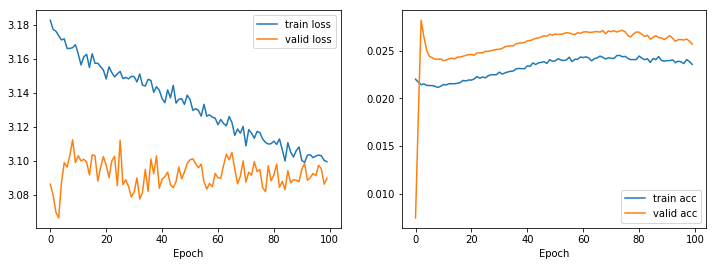

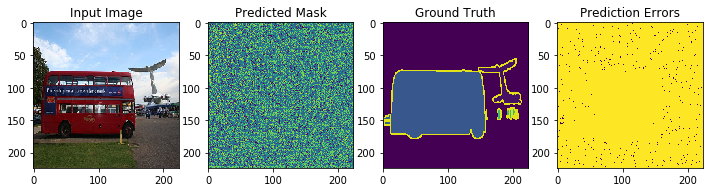

In [59]:
train(nb_epochs=20, trace=trace)

# Validate Model

Optionally load pre-trained model

In [60]:
# pretrained_model_path = './models/model_best.pth'
# model.load_state_dict(torch.load(pretrained_model_path))

In [ ]:
def validate():
    model.eval()
    with torch.no_grad():
        for inputs, targets in val_dataloader:

            logits, _ = model(inputs.to(device))
            logits = logits.cpu()
            
            plot_test_batch(inputs, logits, targets)

This will load every single image from validation set and will plot model prediction against ground truth

In [ ]:
print('Current Epoch', len(trace['epoch']))
validate()

# Old implementation

In [17]:
# TODO: Change me

VOC_CLASSES = ('background',  # always index 0
               'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair',
               'cow', 'diningtable', 'dog', 'horse',
               'motorbike', 'person', 'pottedplant',
               'sheep', 'sofa', 'train', 'tvmonitor')

NUM_CLASSES = len(VOC_CLASSES) + 1

In [18]:
NUM_CLASSES

22

In [8]:
VOC_CLASSES = ('background',  # always index 0
               'pipe')

NUM_CLASSES = len(VOC_CLASSES)

In [9]:
# TODO: Change me

class PascalVOCDataset(torch.utils.data.Dataset):
    """Pascal VOC 2007 Dataset"""
    def __init__(self, list_file, img_dir, mask_dir, transform=None):
        self.images = open(list_file, "rt").read().split("\n")[:-1]
        self.transform = transform

        self.img_extension = ".jpg"
        self.mask_extension = ".png"

        self.image_root_dir = img_dir
        self.mask_root_dir = mask_dir

        self.counts = self.__compute_class_probability()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        name = self.images[index]
        image_path = os.path.join(self.image_root_dir, name + self.img_extension)
        mask_path = os.path.join(self.mask_root_dir, name + self.mask_extension)

        image = self.load_image(path=image_path)
        gt_mask = self.load_mask(path=mask_path)

        data = {
                    'image': torch.FloatTensor(image),
                    'mask' : torch.LongTensor(gt_mask)
                    }

        return data

    def __compute_class_probability(self):
        counts = dict((i, 0) for i in range(NUM_CLASSES))

        for name in self.images:
            mask_path = os.path.join(self.mask_root_dir, name + self.mask_extension)

            raw_image = PIL.Image.open(mask_path).resize((224, 224))
            imx_t = np.array(raw_image).reshape(224*224)
            imx_t[imx_t==255] = len(VOC_CLASSES)

            for i in range(NUM_CLASSES):
                counts[i] += np.sum(imx_t == i)

        return counts

    def get_class_probability(self):
        values = np.array(list(self.counts.values()))
        p_values = values/np.sum(values)

        return torch.Tensor(p_values)

    def load_image(self, path=None):
        raw_image = PIL.Image.open(path)
        raw_image = np.transpose(raw_image.resize((224, 224)), (2,1,0))
        imx_t = np.array(raw_image, dtype=np.float32)/255.0

        return imx_t

    def load_mask(self, path=None):
        raw_image = PIL.Image.open(path)
        raw_image = raw_image.resize((224, 224))
        imx_t = np.array(raw_image)
        # border
        imx_t[imx_t==255] = len(VOC_CLASSES)

        return imx_t

In [10]:
data_root = '/home/marcin/Datasets/VOC2007'
train_txt, val_txt = 'train_mini.txt', 'val_mini.txt'

In [11]:
data_root = '/home/marcin/Datasets/rovco/dataset'
train_txt, val_txt = 'train.txt', 'val.txt'

In [12]:
train_path = os.path.join(data_root, 'ImageSets/Segmentation', train_txt)
val_path = os.path.join(data_root, 'ImageSets/Segmentation/', val_txt)
img_dir = os.path.join(data_root, "JPEGImages")
mask_dir = os.path.join(data_root, "SegmentationClass")

save_dir = './savedir'
checkpoint = None

CUDA = True  # args.gpu is not None
GPU_ID = 0   # args.gpu

BATCH_SIZE = 16

In [13]:
train_dataset = PascalVOCDataset(list_file=train_path,
                                 img_dir=img_dir,
                                 mask_dir=mask_dir)

train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                              batch_size=BATCH_SIZE,
                                              shuffle=True,
                                              num_workers=4)



In [ ]:
print(train_dataset.get_class_probability())

sample = train_dataset[11]
image, mask = sample['image'], sample['mask']

image.transpose_(0, 2)

fig = plt.figure()

a = fig.add_subplot(1,2,1)
plt.imshow(image)

a = fig.add_subplot(1,2,2)
plt.imshow(mask)

plt.show()

In [17]:
test_model_on_random_input = False

if test_model_on_random_input:

    # Model
    model = segnet.SegNet(input_channels=3, output_channels=NUM_CLASSES)

    # print(model)

    img = torch.randn([4, 3, 224, 224])
    output, softmaxed_output = model(img)

    print(output.size())
    print(softmaxed_output.size())

    print(output[0,:,0,0])
    print(softmaxed_output[0,:,0,0].sum())

# Train SegNet

In [18]:
# TODO: Change me

# Constants
NUM_INPUT_CHANNELS = 3
NUM_OUTPUT_CHANNELS = NUM_CLASSES

NUM_EPOCHS = 6000

LEARNING_RATE = 1e-3 # 1e-6
MOMENTUM = 0.9

In [19]:
if CUDA:
    model = segnet.SegNet(input_channels=NUM_INPUT_CHANNELS,
                          output_channels=NUM_OUTPUT_CHANNELS).cuda(GPU_ID)

    class_weights = 1.0/train_dataset.get_class_probability().cuda(GPU_ID)
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights).cuda(GPU_ID)
else:
    model = segnet.SegNet(input_channels=NUM_INPUT_CHANNELS,
                          output_channels=NUM_OUTPUT_CHANNELS)

    class_weights = 1.0/train_dataset.get_class_probability()
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
    
if checkpoint:
    model.load_state_dict(torch.load(args.checkpoint))

In [20]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [21]:
def train():
    is_better = True
    prev_loss = float('inf')

    model.train()

    for epoch in range(NUM_EPOCHS):
        loss_f = 0
        t_start = time.time()

        for batch in train_dataloader:
            input_tensor = torch.autograd.Variable(batch['image'])
            target_tensor = torch.autograd.Variable(batch['mask'])

            if CUDA:
                input_tensor = input_tensor.cuda(GPU_ID)
                target_tensor = target_tensor.cuda(GPU_ID)

            predicted_tensor, softmaxed_tensor = model(input_tensor)


            optimizer.zero_grad()
            loss = criterion(softmaxed_tensor, target_tensor)
            loss.backward()
            optimizer.step()


            loss_f += loss.float()
            prediction_f = softmaxed_tensor.float()

        delta = time.time() - t_start
        is_better = loss_f < prev_loss

        if is_better:
            prev_loss = loss_f
            torch.save(model.state_dict(), os.path.join(save_dir, "model_best.pth"))

        print("Epoch #{}\tLoss: {:.8f}\t Time: {:2f}s".format(epoch+1, loss_f, delta))

In [28]:
train()

Epoch #1	Loss: 0.35000780	 Time: 0.525096s
Epoch #2	Loss: 0.34862185	 Time: 0.524583s
Epoch #3	Loss: 0.34821707	 Time: 0.516271s
Epoch #4	Loss: 0.34586528	 Time: 0.516663s
Epoch #5	Loss: 0.34524012	 Time: 0.519219s
Epoch #6	Loss: 0.34394974	 Time: 0.520299s
Epoch #7	Loss: 0.34403336	 Time: 0.524212s
Epoch #8	Loss: 0.34283078	 Time: 0.511041s
Epoch #9	Loss: 0.33954406	 Time: 0.516970s
Epoch #10	Loss: 0.34080076	 Time: 0.515382s
Epoch #11	Loss: 0.33785093	 Time: 0.505640s
Epoch #12	Loss: 0.34325865	 Time: 0.661593s
Epoch #13	Loss: 0.36328009	 Time: 0.507857s
Epoch #14	Loss: 0.34938964	 Time: 0.514261s
Epoch #15	Loss: 0.34107235	 Time: 0.519991s
Epoch #16	Loss: 0.34347156	 Time: 0.519263s
Epoch #17	Loss: 0.34604922	 Time: 0.514745s
Epoch #18	Loss: 0.34335804	 Time: 0.514310s
Epoch #19	Loss: 0.33804953	 Time: 0.526909s
Epoch #20	Loss: 0.33506152	 Time: 0.511319s
Epoch #21	Loss: 0.33755091	 Time: 0.514496s
Epoch #22	Loss: 0.33654803	 Time: 0.520099s
Epoch #23	Loss: 0.33374000	 Time: 0.51313

KeyboardInterrupt: 

In [23]:
def validate():
    model.eval()

    for batch_idx, batch in enumerate(val_dataloader):
        input_tensor = torch.autograd.Variable(batch['image'])
        target_tensor = torch.autograd.Variable(batch['mask'])

        if CUDA:
            input_tensor = input_tensor.cuda(GPU_ID)
            target_tensor = target_tensor.cuda(GPU_ID)

        predicted_tensor, softmaxed_tensor = model(input_tensor)
        loss = criterion(predicted_tensor, target_tensor)

        for idx, predicted_mask in enumerate(softmaxed_tensor):
            target_mask = target_tensor[idx]
            input_image = input_tensor[idx]

            fig = plt.figure()

            a = fig.add_subplot(1,3,1)
            plt.imshow(input_image.transpose(0, 2).cpu().numpy())
            a.set_title('Input Image')

            a = fig.add_subplot(1,3,2)
            predicted_mx = predicted_mask.detach().cpu().numpy()
            predicted_mx = predicted_mx.argmax(axis=0)
            plt.imshow(predicted_mx)
            a.set_title('Predicted Mask')

            a = fig.add_subplot(1,3,3)
            target_mx = target_mask.detach().cpu().numpy()
            plt.imshow(target_mx)
            a.set_title('Ground Truth')

            #fig.savefig(os.path.join(OUTPUT_DIR, "prediction_{}_{}.png".format(batch_idx, idx)))

            #plt.close(fig)

In [30]:


SAVED_MODEL_PATH = './savedir/model_best.pth'

val_dataset = PascalVOCDataset(list_file=val_path,
                               img_dir=img_dir,
                               mask_dir=mask_dir)

val_dataloader = torch.utils.data.DataLoader(val_dataset,
                                            batch_size=BATCH_SIZE,
                                            shuffle=True,
                                            num_workers=4)

In [16]:
# if CUDA:
#     model = segnet.SegNet(input_channels=NUM_INPUT_CHANNELS,
#                           output_channels=NUM_OUTPUT_CHANNELS).cuda(GPU_ID)

#     class_weights = 1.0/val_dataset.get_class_probability().cuda(GPU_ID)
#     criterion = torch.nn.CrossEntropyLoss(weight=class_weights).cuda(GPU_ID)
# else:
#     model = segnet.SegNet(input_channels=NUM_INPUT_CHANNELS,
#                           output_channels=NUM_OUTPUT_CHANNELS)

#     class_weights = 1.0/val_dataset.get_class_probability()
#     criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

In [ ]:
# model.load_state_dict(torch.load(SAVED_MODEL_PATH))

In [ ]:
validate()